# Natural Language Processing

Natural Language Processing (NLP) is a branch of artificial intelligence that allows computers to understand, interpret and manipulate human language. NLP draws from many disciplines, including computer science and computational linguistics, in its pursuit to fill the gap between human communication and computer understanding.


![](https://image.ibb.co/kkaABL/NLP-768x356.png)

## NLP Pipeline

In all data science processes we have a defined pipeline. In the case of Natural Language Processing, the preprocessing steps differ from how we would approach work with structured data.

![](NLP_Pipeline.png)

## Classification in NLP - Twitter Dataset 

Twitter is a well-known microblog service from which public data can be collected via APIs. NLTK's twitter corpus currently contains a sample of 20k Tweets retrieved from the Twitter Streaming API.

In [86]:
import re
import string
import itertools
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

# Download dataset
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples 
from nltk.corpus import wordnet
from nltk.tag import pos_tag_sents

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


We can see how many JSON files exist in the corpus twitter_samples using the `twitter_samples.fileids()` method:

In [65]:
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [66]:
print('Positive : ',twitter_samples.strings('positive_tweets.json')[0],'\n')
print('Negative : ',twitter_samples.strings('negative_tweets.json')[0])

Positive :  #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :) 

Negative :  hopeless for tmr :(


In [67]:
print('Positive : ',twitter_samples.tokenized('positive_tweets.json')[0],'\n')
print('Negative : ',twitter_samples.tokenized('negative_tweets.json')[0])

Positive :  ['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)'] 

Negative :  ['hopeless', 'for', 'tmr', ':(']


In [68]:
positive_tw = twitter_samples.strings('positive_tweets.json')
negative_tw = twitter_samples.strings('negative_tweets.json')

In [69]:
print('Positive : ',len(positive_tw))
print('Negative : ',len(negative_tw))

Positive :  5000
Negative :  5000


### Preprocessing Tasks

We have several preprocessing tasks when analyzing text:

- Tokenize

<img src="tokens.png" width="500"/>

- Remove Stop Words
- Clean special characters in text
- Stemming/Lemmatization

<img src="stemlem.png" width="500"/>


[Image Source](https://www.slideshare.net/asdkfjqlwef/text-mining-from-bayes-rule-to-de)

We will start by merging the positive and negative tweets into one dataset and give them the tag `pos` or `neg`.

In [70]:
tweets = []
for tweet in positive_tw:
    tweets.append({'tweet':tweet, 'sentiment':'pos'})

# give negative word dictionary 'neg' tag
for tweet in negative_tw:
    tweets.append({'tweet':tweet, 'sentiment':'neg'})

In [71]:
pd.concat([pd.DataFrame(tweets).head(),pd.DataFrame(tweets).tail()])

,tweet,sentiment
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,pos
1,@Lamb2ja Hey James! How odd :/ Please call our...,pos
2,@DespiteOfficial we had a listen last night :)...,pos
3,@97sides CONGRATS :),pos
4,yeaaaah yippppy!!! my accnt verified rqst has...,pos
9995,I wanna change my avi but uSanele :(,neg
9996,MY PUPPY BROKE HER FOOT :(,neg
9997,where's all the jaebum baby pictures :((,neg
9998,But but Mr Ahmad Maslan cooks too :( https://t...,neg
9999,@eawoman As a Hull supporter I am expecting a ...,neg


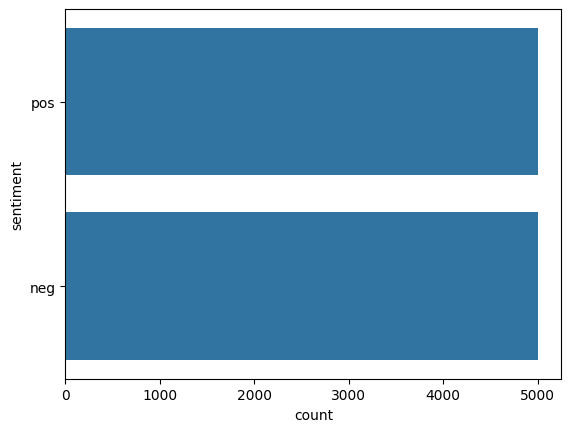

In [72]:
sns.countplot(pd.DataFrame(tweets).sentiment)
plt.show()

Now we need to tokenize the tweet. You can do **sentence tokenize** or **word tokenize**, depending on the type of analysis you're doing. For tweets, you can do a word tokenize by using NLTK's `TweetTokenizer` method.

In [73]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
print('tweet : ', tweets[0]['tweet'])
tweet_tokens = tokenizer.tokenize(tweets[0]['tweet'])
print('tokenized : ',tweet_tokens)

tweet :  #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
tokenized :  ['#followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


In the above output, you can see that special characters and the names of Twitter accounts are included in the tweet. These need to be cleaned, which can easily be done by leveraging regular expressions.

We will define a function to process the tweet:

In [74]:
stopwords_english = stopwords.words('english')
print(stopwords_english)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [75]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [76]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    #stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            tweets_clean.append(word)
            #stem_word = stemmer.stem(word)  # stemming word
            #tweets_clean.append(stem_word)

    return tweets_clean

In [77]:
tweets_pos = []
for tweet in positive_tw:
    tweets_pos.append(process_tweet(tweet))

# give negative word dictionary 'neg' tag
tweets_neg = []
for tweet in negative_tw:
    tweets_neg.append(process_tweet(tweet))

In [78]:
tweets_pos[:1]

[['followfriday', 'top', 'engaged', 'members', 'community', 'week', ':)']]

In [79]:
all_tw_pos = list(itertools.chain(*tweets_pos))
all_tw_neg = list(itertools.chain(*tweets_neg))

In [80]:
freq_all_tw_pos = nltk.FreqDist(all_tw_pos)
freq_all_tw_pos = pd.DataFrame(list(freq_all_tw_pos.items()), columns = ["Word","Frequency"])
freq_all_tw_pos.sort_values('Frequency',ascending=False, inplace = True)
freq_all_tw_pos.reset_index(drop = True, inplace=True)
freq_all_tw_pos.head()

,Word,Frequency
0,:),3568
1,:-),692
2,:D,629
3,thanks,370
4,...,289


In [81]:
freq_all_tw_neg = nltk.FreqDist(all_tw_neg)
freq_all_tw_neg = pd.DataFrame(list(freq_all_tw_neg.items()), columns = ["Word","Frequency"])
freq_all_tw_neg.sort_values('Frequency',ascending=False, inplace = True)
freq_all_tw_neg.reset_index(drop = True, inplace=True)
freq_all_tw_neg.head()

,Word,Frequency
0,:(,4571
1,:-(,493
2,i'm,343
3,...,331
4,please,274


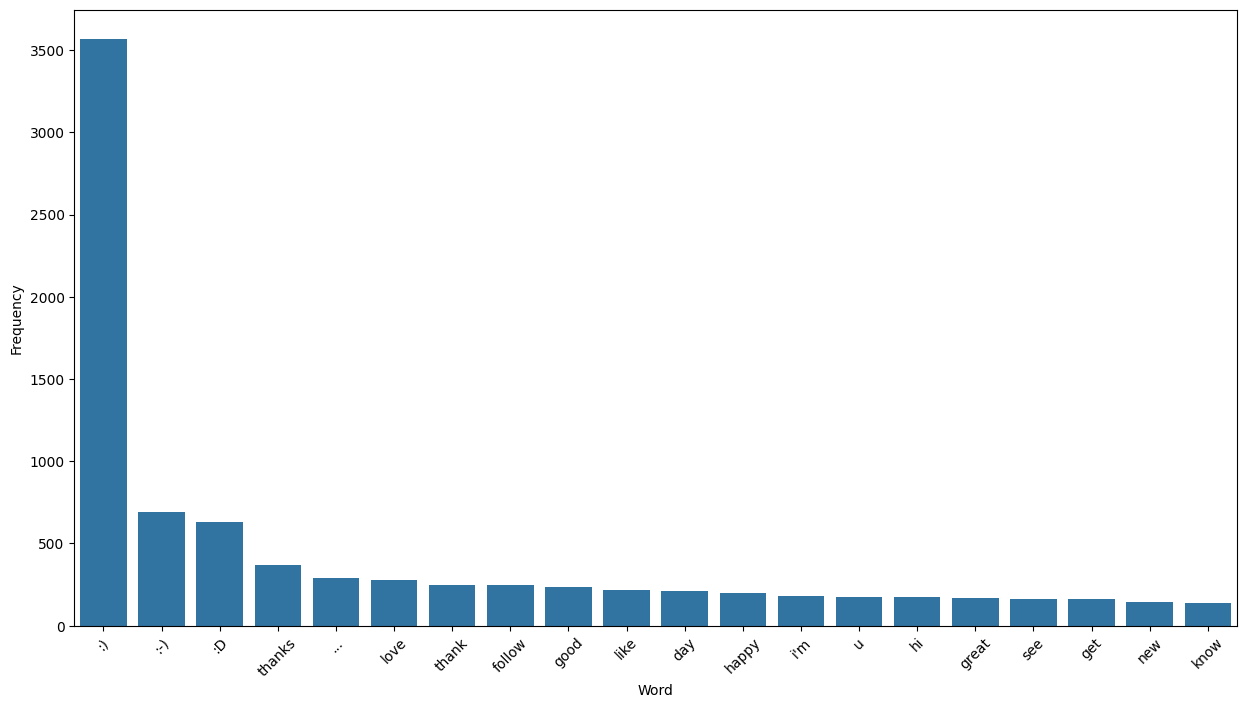

In [82]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = freq_all_tw_pos.iloc[:20].Word, y = freq_all_tw_pos.iloc[:20].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(45)
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12299 (\N{RIGHT DOUBLE ANGLE BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


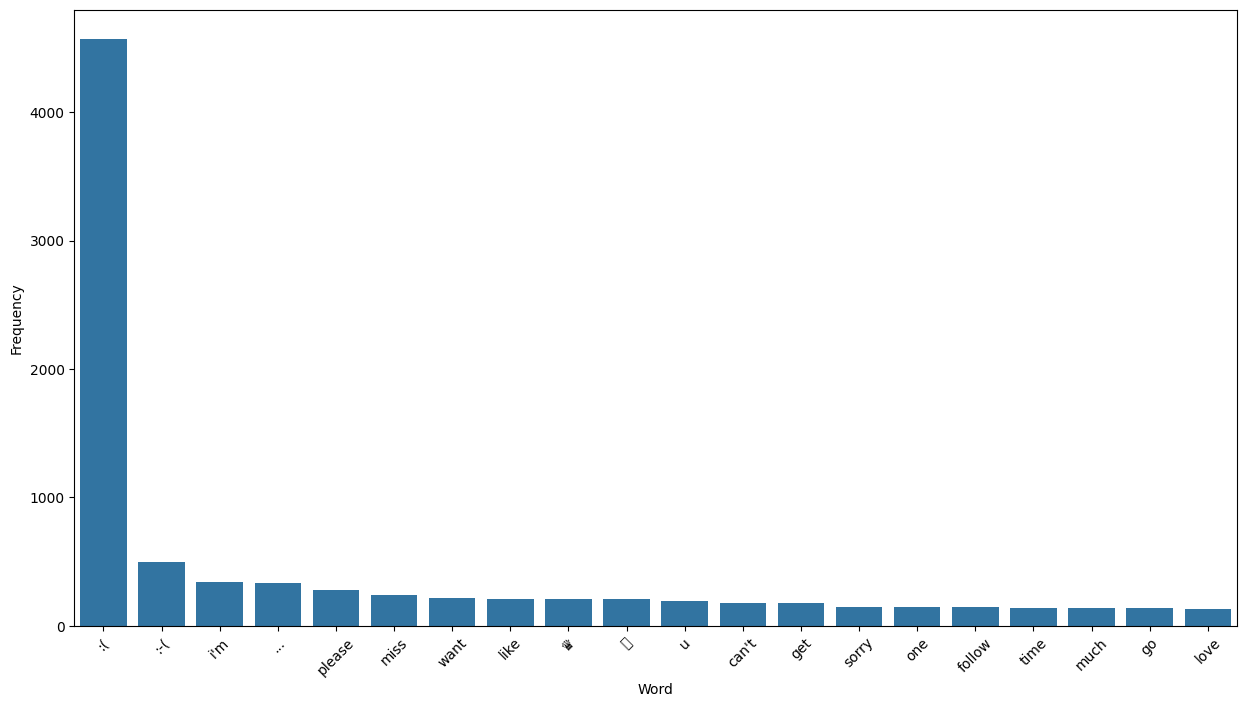

In [83]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = freq_all_tw_neg.iloc[:20].Word, y = freq_all_tw_neg.iloc[:20].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(45)
plt.show()

Now, we will see how Stemmer and Lemmatizer processes work.

In [84]:
example = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."

tokens = nltk.word_tokenize(example)

print(tokens)

['He', 'was', 'running', 'and', 'eating', 'at', 'same', 'time', '.', 'He', 'has', 'bad', 'habit', 'of', 'swimming', 'after', 'playing', 'long', 'hours', 'in', 'the', 'Sun', '.']


In [85]:
example = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."

tokens = nltk.word_tokenize(example)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Stem and lemmatize
print("{0:20}{1:20}{2:20}".format("Word","Stemmer","Lemma"))
for word in tokens:
    print ("{0:20}{1:20}{2:20}".format(word,stemmer.stem(word),lemmatizer.lemmatize(word)))

Word                Stemmer             Lemma               
He                  he                  He                  
was                 wa                  wa                  
running             run                 running             
and                 and                 and                 
eating              eat                 eating              
at                  at                  at                  
same                same                same                
time                time                time                
.                   .                   .                   
He                  he                  He                  
has                 ha                  ha                  
bad                 bad                 bad                 
habit               habit               habit               
of                  of                  of                  
swimming            swim                swimming            
after               afte

For the Lemmatize process, it is important to know what role a word plays in a sentence. In NLTK, we have the method `pos_tag` that return this role.

<img src="https://t1.daumcdn.net/cfile/tistory/2424A54E542E3F6906" width="250"/>


In [88]:
print(nltk.pos_tag(tokens))

[('He', 'PRP'), ('was', 'VBD'), ('running', 'VBG'), ('and', 'CC'), ('eating', 'VBG'), ('at', 'IN'), ('same', 'JJ'), ('time', 'NN'), ('.', '.'), ('He', 'PRP'), ('has', 'VBZ'), ('bad', 'JJ'), ('habit', 'NN'), ('of', 'IN'), ('swimming', 'NN'), ('after', 'IN'), ('playing', 'VBG'), ('long', 'JJ'), ('hours', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('Sun', 'NNP'), ('.', '.')]


In [90]:
print(process_tweet(tweets[0]['tweet']))
print(nltk.pos_tag(process_tweet(tweets[0]['tweet'])))

['followfriday', 'top', 'engaged', 'members', 'community', 'week', ':)']
[('followfriday', 'JJ'), ('top', 'VB'), ('engaged', 'JJ'), ('members', 'NNS'), ('community', 'NN'), ('week', 'NN'), (':)', 'NN')]


Let's define a function that returns the `pos_tag` of a word so that we may use it in the lemmatize process:

In [91]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    #print(tag)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [92]:
print("{0:20}{1:20}{2:20}{3:20}{4:20}".format("Word","Stemmer","Lemma","Type","New Lemma"))
for word in tokens:
    print ("{0:20}{1:20}{2:20}{3:20}{4:20}".format(word,stemmer.stem(word),lemmatizer.lemmatize(word),get_wordnet_pos(word),lemmatizer.lemmatize(word, get_wordnet_pos(word))))

Word                Stemmer             Lemma               Type                New Lemma           
He                  he                  He                  n                   He                  
was                 wa                  wa                  v                   be                  
running             run                 running             v                   run                 
and                 and                 and                 n                   and                 
eating              eat                 eating              v                   eat                 
at                  at                  at                  n                   at                  
same                same                same                a                   same                
time                time                time                n                   time                
.                   .                   .                   n                   .          

In [93]:
def process_tweet(tweet,stem = False, lemma= False, own_stop_words=[]):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stopwords_english = stopwords.words('english')
    
    stopwords_new = stopwords_english + own_stop_words
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_new and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            if lemma is False and stem is False:
                tweets_clean.append(word)
            elif stem is True and lemma is False:
                stemmer = PorterStemmer()
                stem_word = stemmer.stem(word)  # stemming word
                tweets_clean.append(stem_word)
            elif lemma is True and stem is False:
                lemmatizer = WordNetLemmatizer()
                lemma_word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                tweets_clean.append(lemma_word)
    return tweets_clean

In [94]:
own_stop_words = ["i'm","follow","u"]
tweets = []
for tweet in positive_tw:
    tweets.append({'tweet':' '.join(process_tweet(tweet,lemma = True,own_stop_words=own_stop_words)),'sentiment':'pos'})

# give negative word dictionary 'neg' tag
for tweet in negative_tw:
    tweets.append({'tweet':' '.join(process_tweet(tweet,lemma = True,own_stop_words=own_stop_words)),'sentiment':'neg'})

In [97]:
data = pd.DataFrame(tweets)
pd.concat([data.head(),data.tail()])

,tweet,sentiment
0,followfriday top engage member community week :),pos
1,hey james odd :/ please call contact centre 02...,pos
2,listen last night :) bleed amaze track scotland,pos
3,congrats :),pos
4,yeaaah yipppy accnt verify rqst succeed get bl...,pos
9995,wanna change avi usanele :(,neg
9996,puppy broke foot :(,neg
9997,where's jaebum baby picture :(,neg
9998,mr ahmad maslan cook :(,neg
9999,hull supporter expect misserable week :-(,neg


In [99]:
data.sentiment = data.sentiment.replace({'pos':1,'neg':0})
pd.concat([data.head(),data.tail()])

,tweet,sentiment
0,followfriday top engage member community week :),1
1,hey james odd :/ please call contact centre 02...,1
2,listen last night :) bleed amaze track scotland,1
3,congrats :),1
4,yeaaah yipppy accnt verify rqst succeed get bl...,1
9995,wanna change avi usanele :(,0
9996,puppy broke foot :(,0
9997,where's jaebum baby picture :(,0
9998,mr ahmad maslan cook :(,0
9999,hull supporter expect misserable week :-(,0


In [100]:
list_tweets = list(data['tweet'].values)
sentiment = data['sentiment'].values

In [101]:
list_tweets[:2]

['followfriday top engage member community week :)',
 'hey james odd :/ please call contact centre 02392441234 able assist :) many thanks']

In [102]:
sentiment[:2]

array([1, 1])

`CountVectorizer` provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words. Using this vocabulary, you can also use `CountVectorizer` to encode new documents.

In [103]:
# define max features
max_features=100

# each instance will have 10 features
count_vector=CountVectorizer(max_features=max_features,ngram_range=(1, 2)) # stop_words="english" , ngram_range=(1, 2)

In [105]:

dir(count_vector)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_char_ngrams',
 '_char_wb_ngrams',
 '_check_feature_names',
 '_check_n_features',
 '_check_stop_words_consistency',
 '_check_vocabulary',
 '_count_vocab',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_limit_features',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sort_features',
 '_stop_words_id',
 '_validate_data',
 '_

In [106]:
matrix_tweets_cv = count_vector.fit_transform(list_tweets)

# getting the words
all_words = count_vector.get_feature_names_out()

# visualize first 50 words
print("First 50 words: ",all_words[0:50])

First 50 words:  ['always' 'back' 'bad' 'best' 'birthday' 'can' 'come' 'could' 'day'
 'enjoy' 'even' 'everyone' 'feel' 'follow' 'friday' 'friend' 'fuck' 'fun'
 'get' 'give' 'go' 'good' 'great' 'guy' 'happy' 'help' 'hey' 'hi' 'home'
 'hope' 'im' 'keep' 'kik' 'know' 'last' 'let' 'life' 'like' 'll' 'lol'
 'look' 'lot' 'love' 'make' 'miss' 'morning' 'much' 'need' 'never' 'new']


In [107]:
print(count_vector.vocabulary_)

{'week': 91, 'hey': 26, 'please': 57, 'thanks': 75, 'last': 34, 'night': 52, 'get': 18, 'day': 8, 'one': 54, 'like': 37, 'keep': 31, 'wait': 85, 'hope': 29, 'enjoy': 9, 'happy': 24, 'friday': 14, 'time': 79, 'new': 49, 'go': 20, 'well': 93, 'love': 42, 'know': 33, 'great': 22, 'today': 80, 'friend': 15, 'help': 25, 'work': 95, 'hi': 27, 'need': 47, 'sure': 71, 'thing': 77, 've': 84, 'fun': 17, 'yeah': 97, 'lol': 39, 'see': 63, 'year': 98, 'thank': 74, 'we': 90, 'll': 38, 'kik': 32, 'come': 6, 'lot': 41, 'everyone': 11, 'watch': 88, 'oh': 53, 'look': 40, 'next': 50, 'make': 43, 'feel': 12, 'never': 48, 'good': 21, 'best': 3, 'wish': 94, 'would': 96, 'im': 30, 'talk': 73, 'someone': 66, 'yes': 99, 'can': 5, 'still': 70, 'think': 78, 'let': 35, 'take': 72, 'fuck': 16, 'weekend': 92, 'really': 59, 'sleep': 64, 'birthday': 4, 'want': 87, 'miss': 44, 'morning': 45, 'that': 76, 'try': 81, 'start': 69, 'right': 60, 'back': 1, 'even': 10, 'home': 28, 'soon': 67, 'life': 36, 'could': 7, 'always'

In [108]:
matrix_tweets_cv.toarray()[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [109]:
x = matrix_tweets_cv.toarray()
y = sentiment

train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [110]:
print(train_x.shape)
print(test_x.shape)

(8000, 100)
(2000, 100)


In [111]:
(unique, counts) = np.unique(train_y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 4000]
 [   1 4000]]


In [112]:
(unique, counts) = np.unique(test_y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 1000]
 [   1 1000]]


Now experimenting with models.

In [113]:
def confusion(ytest,y_pred):
    names=["Negative","Positive"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()
    return

### Naive Bayes

In [114]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb.fit(train_x,train_y)
print("acc : ", nb.score(test_x,test_y))

acc :  0.666


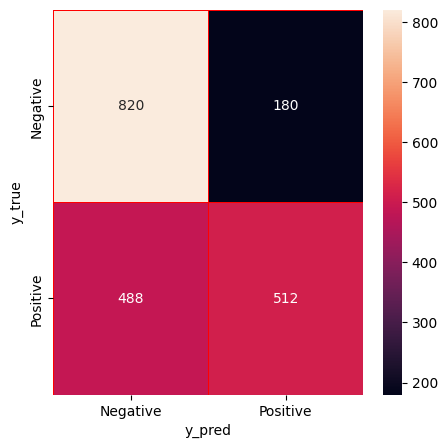

In [115]:
y_pred=nb.predict(test_x)
confusion(test_y,y_pred)

Word counts are a good starting point but are very basic. One issue with simple counts is that some words like “the” will appear many times and their large count values will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies. The most popular way of doing this is called TF-IDF. This is an acronym that stands for “Term Frequency – Inverse Document Frequency". It is calculated as so:

<img src="https://miro.medium.com/max/1400/1*mu6G-cBmWlENS4pWHEnGcg@2x.jpeg" width="500"/>



In [117]:
vectorizer = TfidfVectorizer(max_features=max_features,ngram_range=(1, 2))

matrix_tweets_tf = vectorizer.fit_transform(list_tweets)

# getting the words
all_words = vectorizer.get_feature_names_out()

# visualize first 50 words
print("First 50 words: ",all_words[0:50])

First 50 words:  ['always' 'back' 'bad' 'best' 'birthday' 'can' 'come' 'could' 'day'
 'enjoy' 'even' 'everyone' 'feel' 'follow' 'friday' 'friend' 'fuck' 'fun'
 'get' 'give' 'go' 'good' 'great' 'guy' 'happy' 'help' 'hey' 'hi' 'home'
 'hope' 'im' 'keep' 'kik' 'know' 'last' 'let' 'life' 'like' 'll' 'lol'
 'look' 'lot' 'love' 'make' 'miss' 'morning' 'much' 'need' 'never' 'new']


In [118]:
print(vectorizer.vocabulary_)

{'week': 91, 'hey': 26, 'please': 57, 'thanks': 75, 'last': 34, 'night': 52, 'get': 18, 'day': 8, 'one': 54, 'like': 37, 'keep': 31, 'wait': 85, 'hope': 29, 'enjoy': 9, 'happy': 24, 'friday': 14, 'time': 79, 'new': 49, 'go': 20, 'well': 93, 'love': 42, 'know': 33, 'great': 22, 'today': 80, 'friend': 15, 'help': 25, 'work': 95, 'hi': 27, 'need': 47, 'sure': 71, 'thing': 77, 've': 84, 'fun': 17, 'yeah': 97, 'lol': 39, 'see': 63, 'year': 98, 'thank': 74, 'we': 90, 'll': 38, 'kik': 32, 'come': 6, 'lot': 41, 'everyone': 11, 'watch': 88, 'oh': 53, 'look': 40, 'next': 50, 'make': 43, 'feel': 12, 'never': 48, 'good': 21, 'best': 3, 'wish': 94, 'would': 96, 'im': 30, 'talk': 73, 'someone': 66, 'yes': 99, 'can': 5, 'still': 70, 'think': 78, 'let': 35, 'take': 72, 'fuck': 16, 'weekend': 92, 'really': 59, 'sleep': 64, 'birthday': 4, 'want': 87, 'miss': 44, 'morning': 45, 'that': 76, 'try': 81, 'start': 69, 'right': 60, 'back': 1, 'even': 10, 'home': 28, 'soon': 67, 'life': 36, 'could': 7, 'always'

In [119]:
matrix_tweets_tf.toarray()[:5]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [120]:
x = matrix_tweets_tf.toarray()
y = sentiment

train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [121]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb.fit(train_x,train_y)
print("acc : ", nb.score(test_x,test_y))

acc :  0.6615


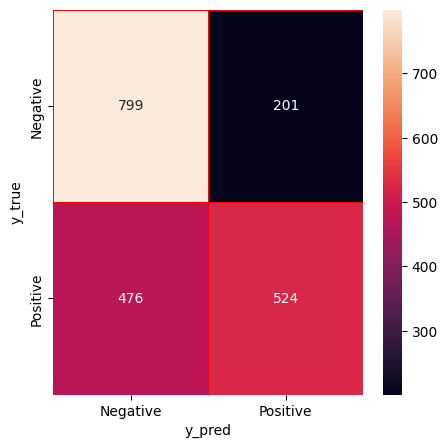

In [122]:
y_pred=nb.predict(test_x)
confusion(test_y,y_pred)

### SVM

In [123]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(train_x,train_y)
svc.score(test_x,test_y)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.67

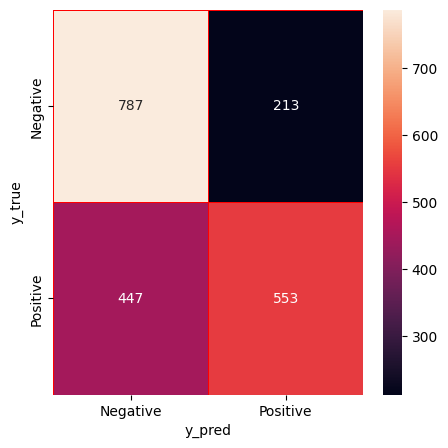

In [124]:
y_pred=svc.predict(test_x)
confusion(test_y,y_pred)

### Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(train_x,train_y)
print("acc: ",rf.score(test_x,test_y))

acc:  0.6585


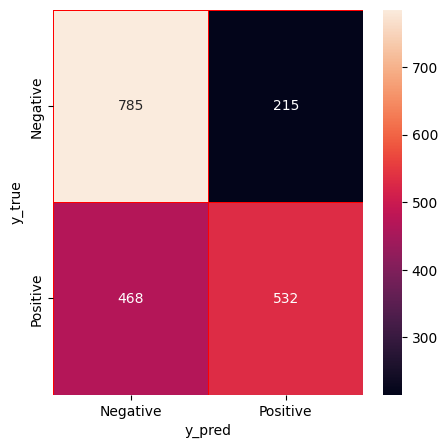

In [126]:
y_pred=rf.predict(test_x)
confusion(test_y,y_pred)

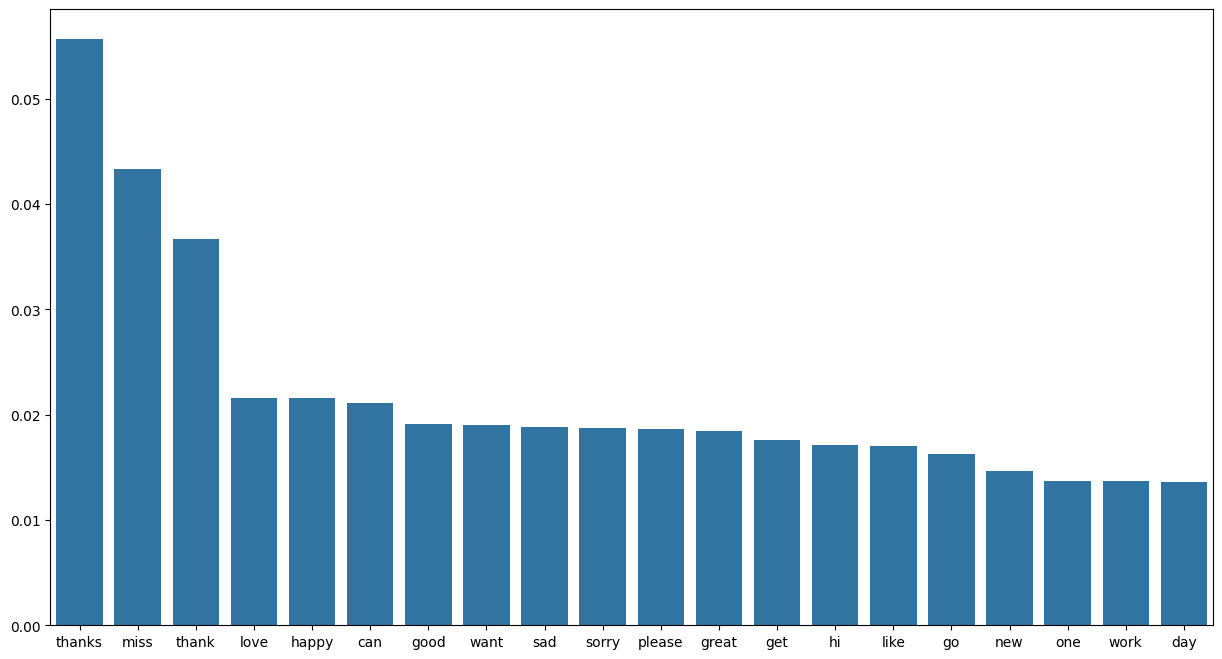

In [130]:
importances = rf.feature_importances_

all_words = vectorizer.get_feature_names_out()
columns = all_words

# Sort by importance and take the first 20
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Graph the results
plt.figure(figsize = (15,8))
sns.barplot(x=selected_columns, y=selected_importances)
plt.show()